In [37]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial
from aesthetics.plotting import adjust_spines

# imports from tensorflow/models/tutorial/image/imagenet/classify_image.py
import argparse
import os.path
import re
import sys
import tarfile
from six.moves import urllib

# from deepdream notebook http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
from IPython.display import clear_output, Image, display, HTML

%matplotlib inline

plt.style.use('deepretina')

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
FLAGS = None

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long


In [2]:
class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

In [4]:
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

In [5]:
def run_inference_on_image(image):
  """Runs inference on an image.

  Args:
    image: Image file name.

  Returns:
    Nothing
  """
  if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
  image_data = tf.gfile.FastGFile(image, 'rb').read()

  # Creates graph from saved GraphDef.
  create_graph()

  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

    # Creates node ID --> English string lookup.
    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
    for node_id in top_k:
      human_string = node_lookup.id_to_string(node_id)
      score = predictions[node_id]
      print('%s (score = %.5f)' % (human_string, score))

# Get to the right directory

In [7]:
cd '~/code/models/tutorials/image/imagenet'

/home/lane/ssd/code/models/tutorials/image/imagenet


In [8]:
ls

BUILD  classify_image.py


# Specify the saved model and image directories

In [10]:
DATA_URL

'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

In [13]:
parser = argparse.ArgumentParser()
FLAGS, unparsed = parser.parse_known_args()

#### Specify image and model directories

In [17]:
FLAGS.model_dir = '/tmp/imagenet'
FLAGS.image_file = '/tmp/imagenet/cropped_panda.jpg'

In [18]:
image = (FLAGS.image_file if FLAGS.image_file else
           os.path.join(FLAGS.model_dir, 'cropped_panda.jpg'))

#### Load binary image

In [20]:
if not tf.gfile.Exists(image):
    tf.logging.fatal('File does not exist %s', image)
image_data = tf.gfile.FastGFile(image, 'rb').read()

#### Create TF graph

In [22]:
create_graph()

In [24]:
# [n.name for n in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]
with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')

In [33]:
sess.graph.get_collection()

[]

In [34]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['DecodeJpeg/contents',
 'DecodeJpeg',
 'Cast',
 'ExpandDims/dim',
 'ExpandDims',
 'ResizeBilinear/size',
 'ResizeBilinear',
 'Sub/y',
 'Sub',
 'Mul/y',
 'Mul',
 'conv/conv2d_params',
 'conv/Conv2D',
 'conv/batchnorm/beta',
 'conv/batchnorm/gamma',
 'conv/batchnorm/moving_mean',
 'conv/batchnorm/moving_variance',
 'conv/batchnorm',
 'conv/CheckNumerics',
 'conv/control_dependency',
 'conv',
 'conv_1/conv2d_params',
 'conv_1/Conv2D',
 'conv_1/batchnorm/beta',
 'conv_1/batchnorm/gamma',
 'conv_1/batchnorm/moving_mean',
 'conv_1/batchnorm/moving_variance',
 'conv_1/batchnorm',
 'conv_1/CheckNumerics',
 'conv_1/control_dependency',
 'conv_1',
 'conv_2/conv2d_params',
 'conv_2/Conv2D',
 'conv_2/batchnorm/beta',
 'conv_2/batchnorm/gamma',
 'conv_2/batchnorm/moving_mean',
 'conv_2/batchnorm/moving_variance',
 'conv_2/batchnorm',
 'conv_2/CheckNumerics',
 'conv_2/control_dependency',
 'conv_2',
 'pool/CheckNumerics',
 'pool/control_dependency',
 'pool',
 'conv_3/conv2d_params',
 'conv_3/Conv2D

In [41]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [42]:
show_graph(sess.graph)

In [45]:
layers = [op.name for op in sess.graph.get_operations() if op.type=='Conv2D']
feature_nums = [int(sess.graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 94
Total number of feature channels: 17216


## Look at softmax predictions (last layer)

In [46]:
# [n.name for n in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]
with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(softmax_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    predictions = np.squeeze(predictions)

In [47]:
len(predictions)

1008

In [55]:
bloop = predictions.argsort()

In [56]:
bloop[:5]

array([383, 138, 171, 762, 939])

In [60]:
predictions[bloop[:5]]

array([  1.13824717e-05,   1.15990142e-05,   1.73340632e-05,
         1.78354567e-05,   1.83854772e-05], dtype=float32)

In [61]:
predictions[bloop[-5:]][::-1]

array([ 0.89107335,  0.00779056,  0.00295913,  0.00146577,  0.00117424], dtype=float32)

giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (score = 0.89107)
indri, indris, Indri indri, Indri brevicaudatus (score = 0.00779)
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (score = 0.00296)
custard apple (score = 0.00147)
earthstar (score = 0.00117)
cock (score = 0.00001)
macaque (score = 0.00001)
Shetland sheepdog, Shetland sheep dog, Shetland (score = 0.00002)
chest (score = 0.00002)
purse (score = 0.00002)


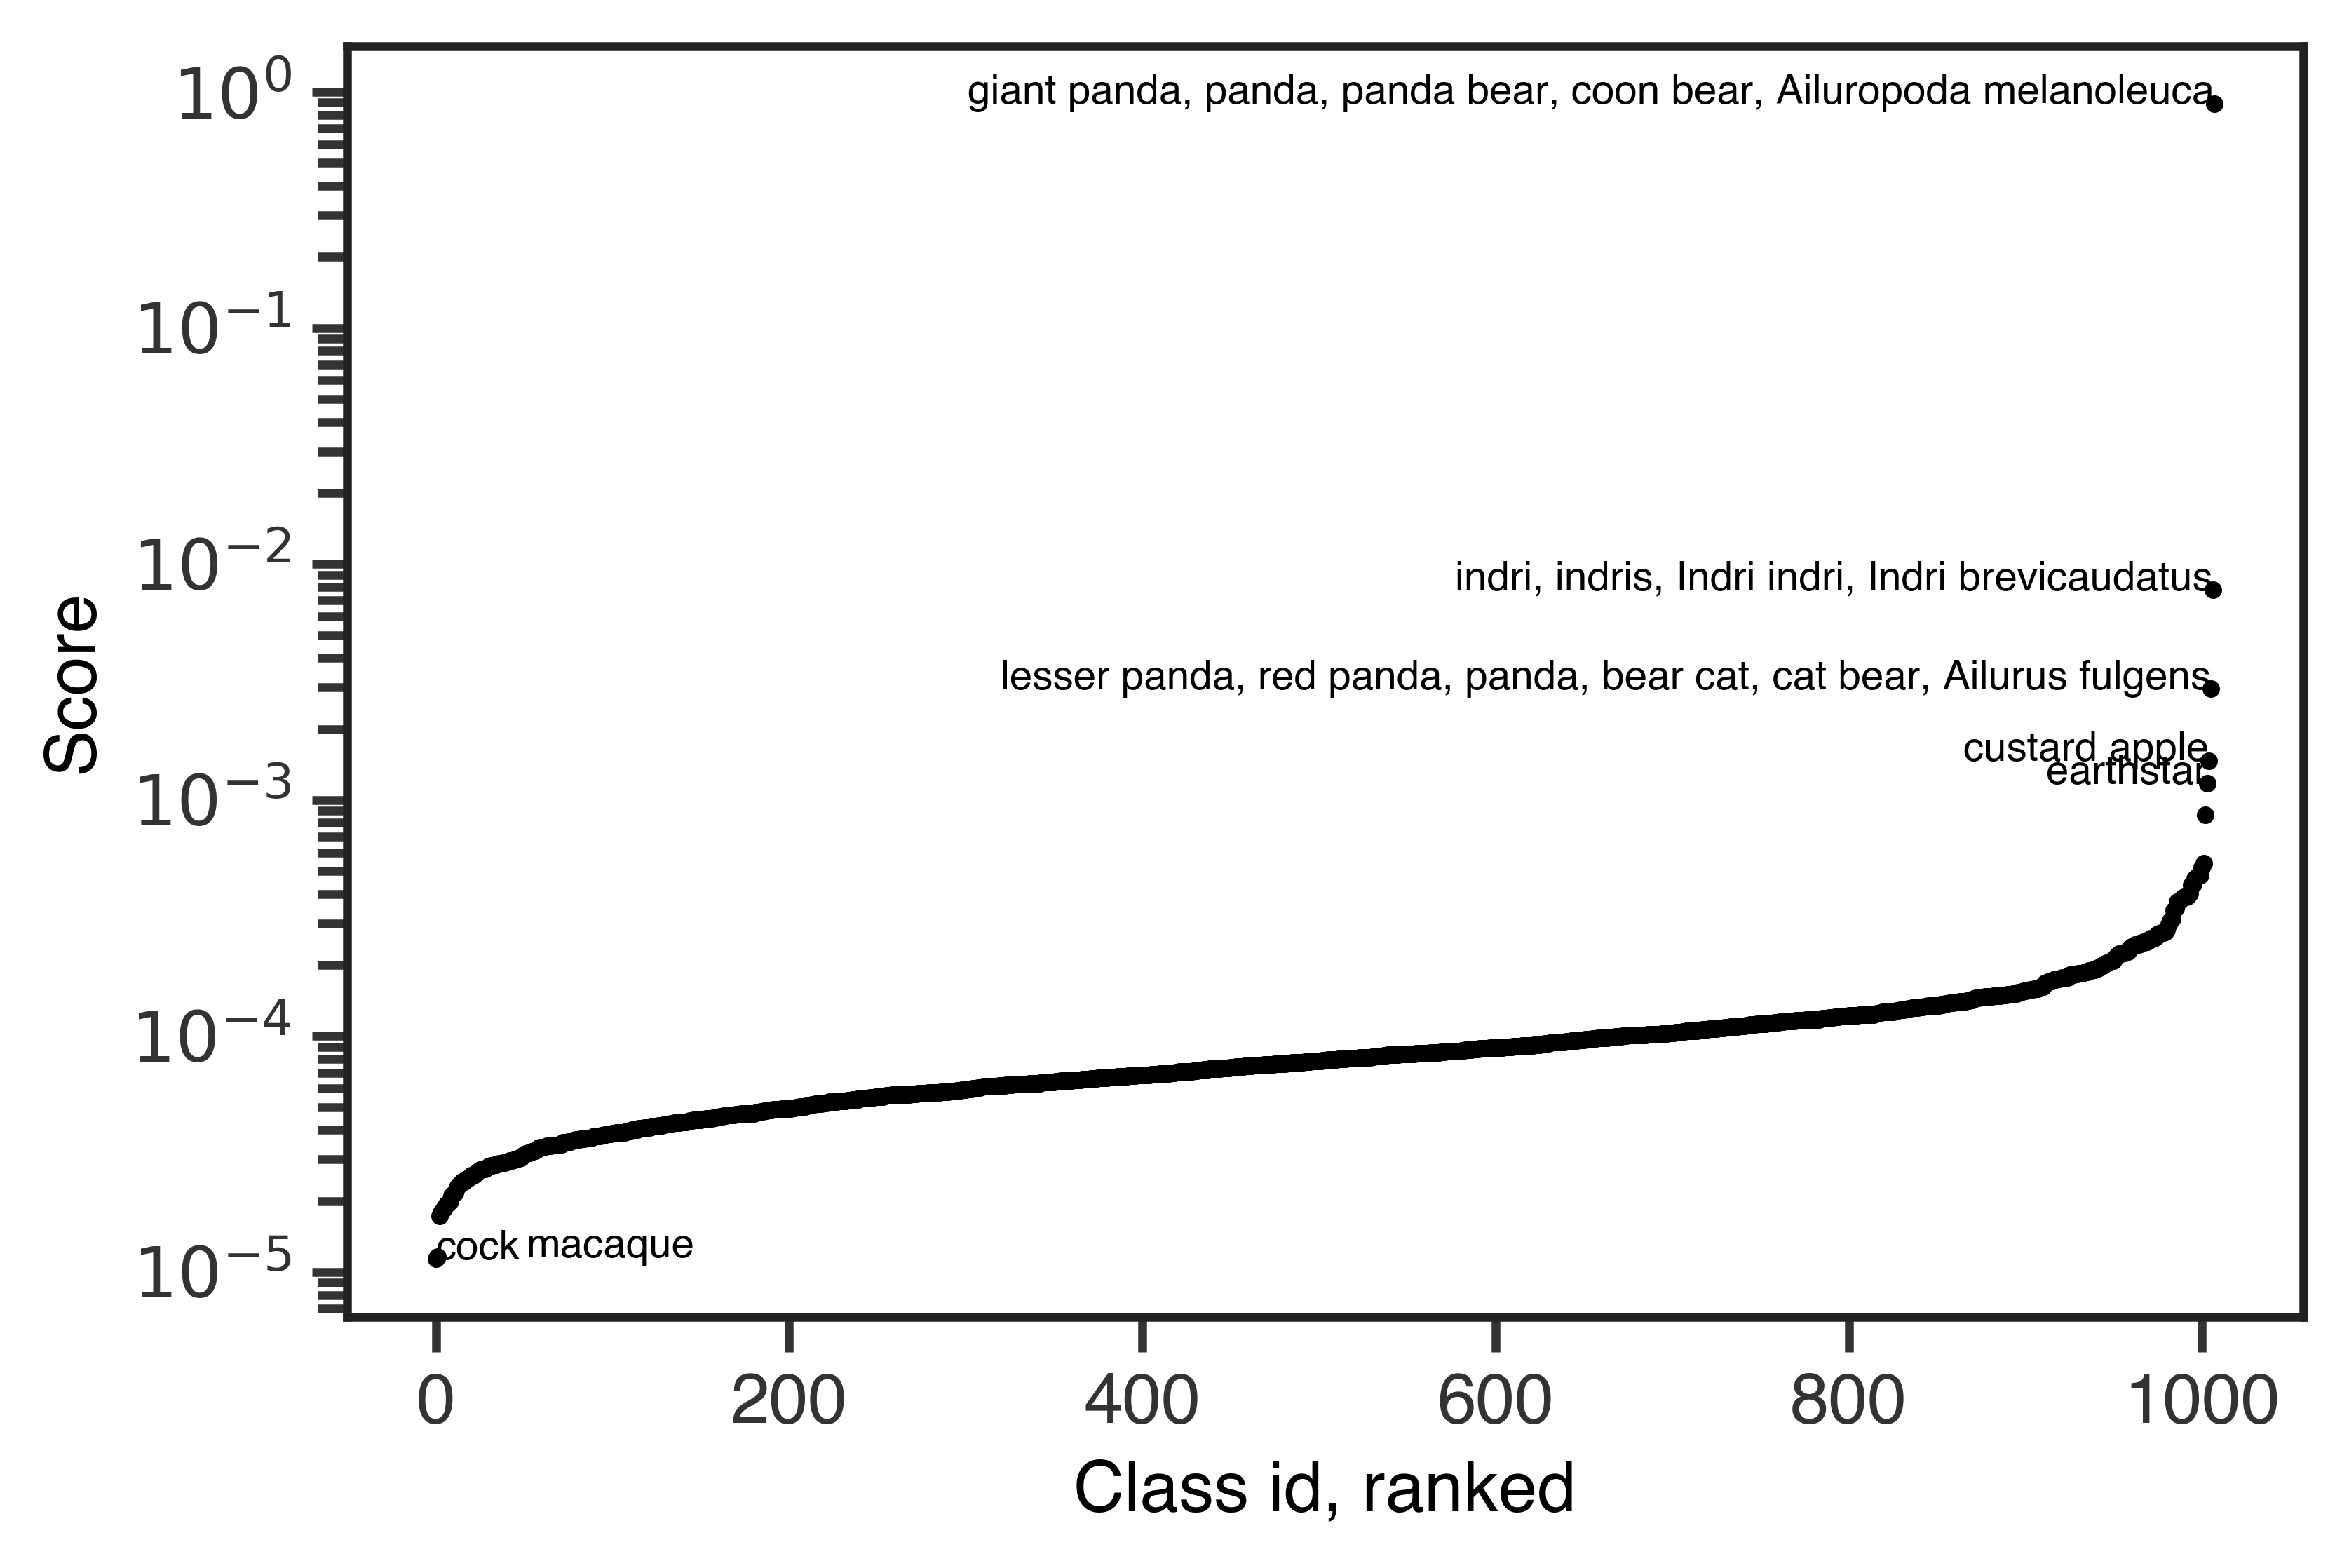

In [71]:
FLAGS.num_top_predictions = 5

# Creates node ID --> English string lookup.
node_lookup = NodeLookup()

top_k = predictions.argsort()[-FLAGS.num_top_predictions:][::-1]
bottom_k = predictions.argsort()[:FLAGS.num_top_predictions]

top_k_names = []
top_k_scores = []
for node_id in top_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)' % (human_string, score))
    top_k_names.append(human_string)
    top_k_scores.append(score)
    
bottom_k_names = []
bottom_k_scores = []
for node_id in bottom_k:
    human_string = node_lookup.id_to_string(node_id)
    score = predictions[node_id]
    print('%s (score = %.5f)' % (human_string, score))
    bottom_k_names.append(human_string)
    bottom_k_scores.append(score)


plt.plot(sorted(predictions), '.', markersize=5, color='k')
for i,name in enumerate(top_k_names):
    plt.text(len(predictions) - i - 1, top_k_scores[i], name, fontsize=7, horizontalalignment='right')

for i,name in enumerate(bottom_k_names[:2]):
    plt.text(i + i*50, bottom_k_scores[i], name, fontsize=7)
    
plt.yscale('log')
plt.ylabel('Score')
plt.xlabel('Class id, ranked')

In [76]:
# [n.name for n in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)]
with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    conv_tensor = sess.graph.get_tensor_by_name('conv:0')
    visualization = sess.run(conv_tensor,
                           {'DecodeJpeg/contents:0': image_data})
    visualization = np.squeeze(visualization)

In [77]:
visualization.shape

(149, 149, 32)

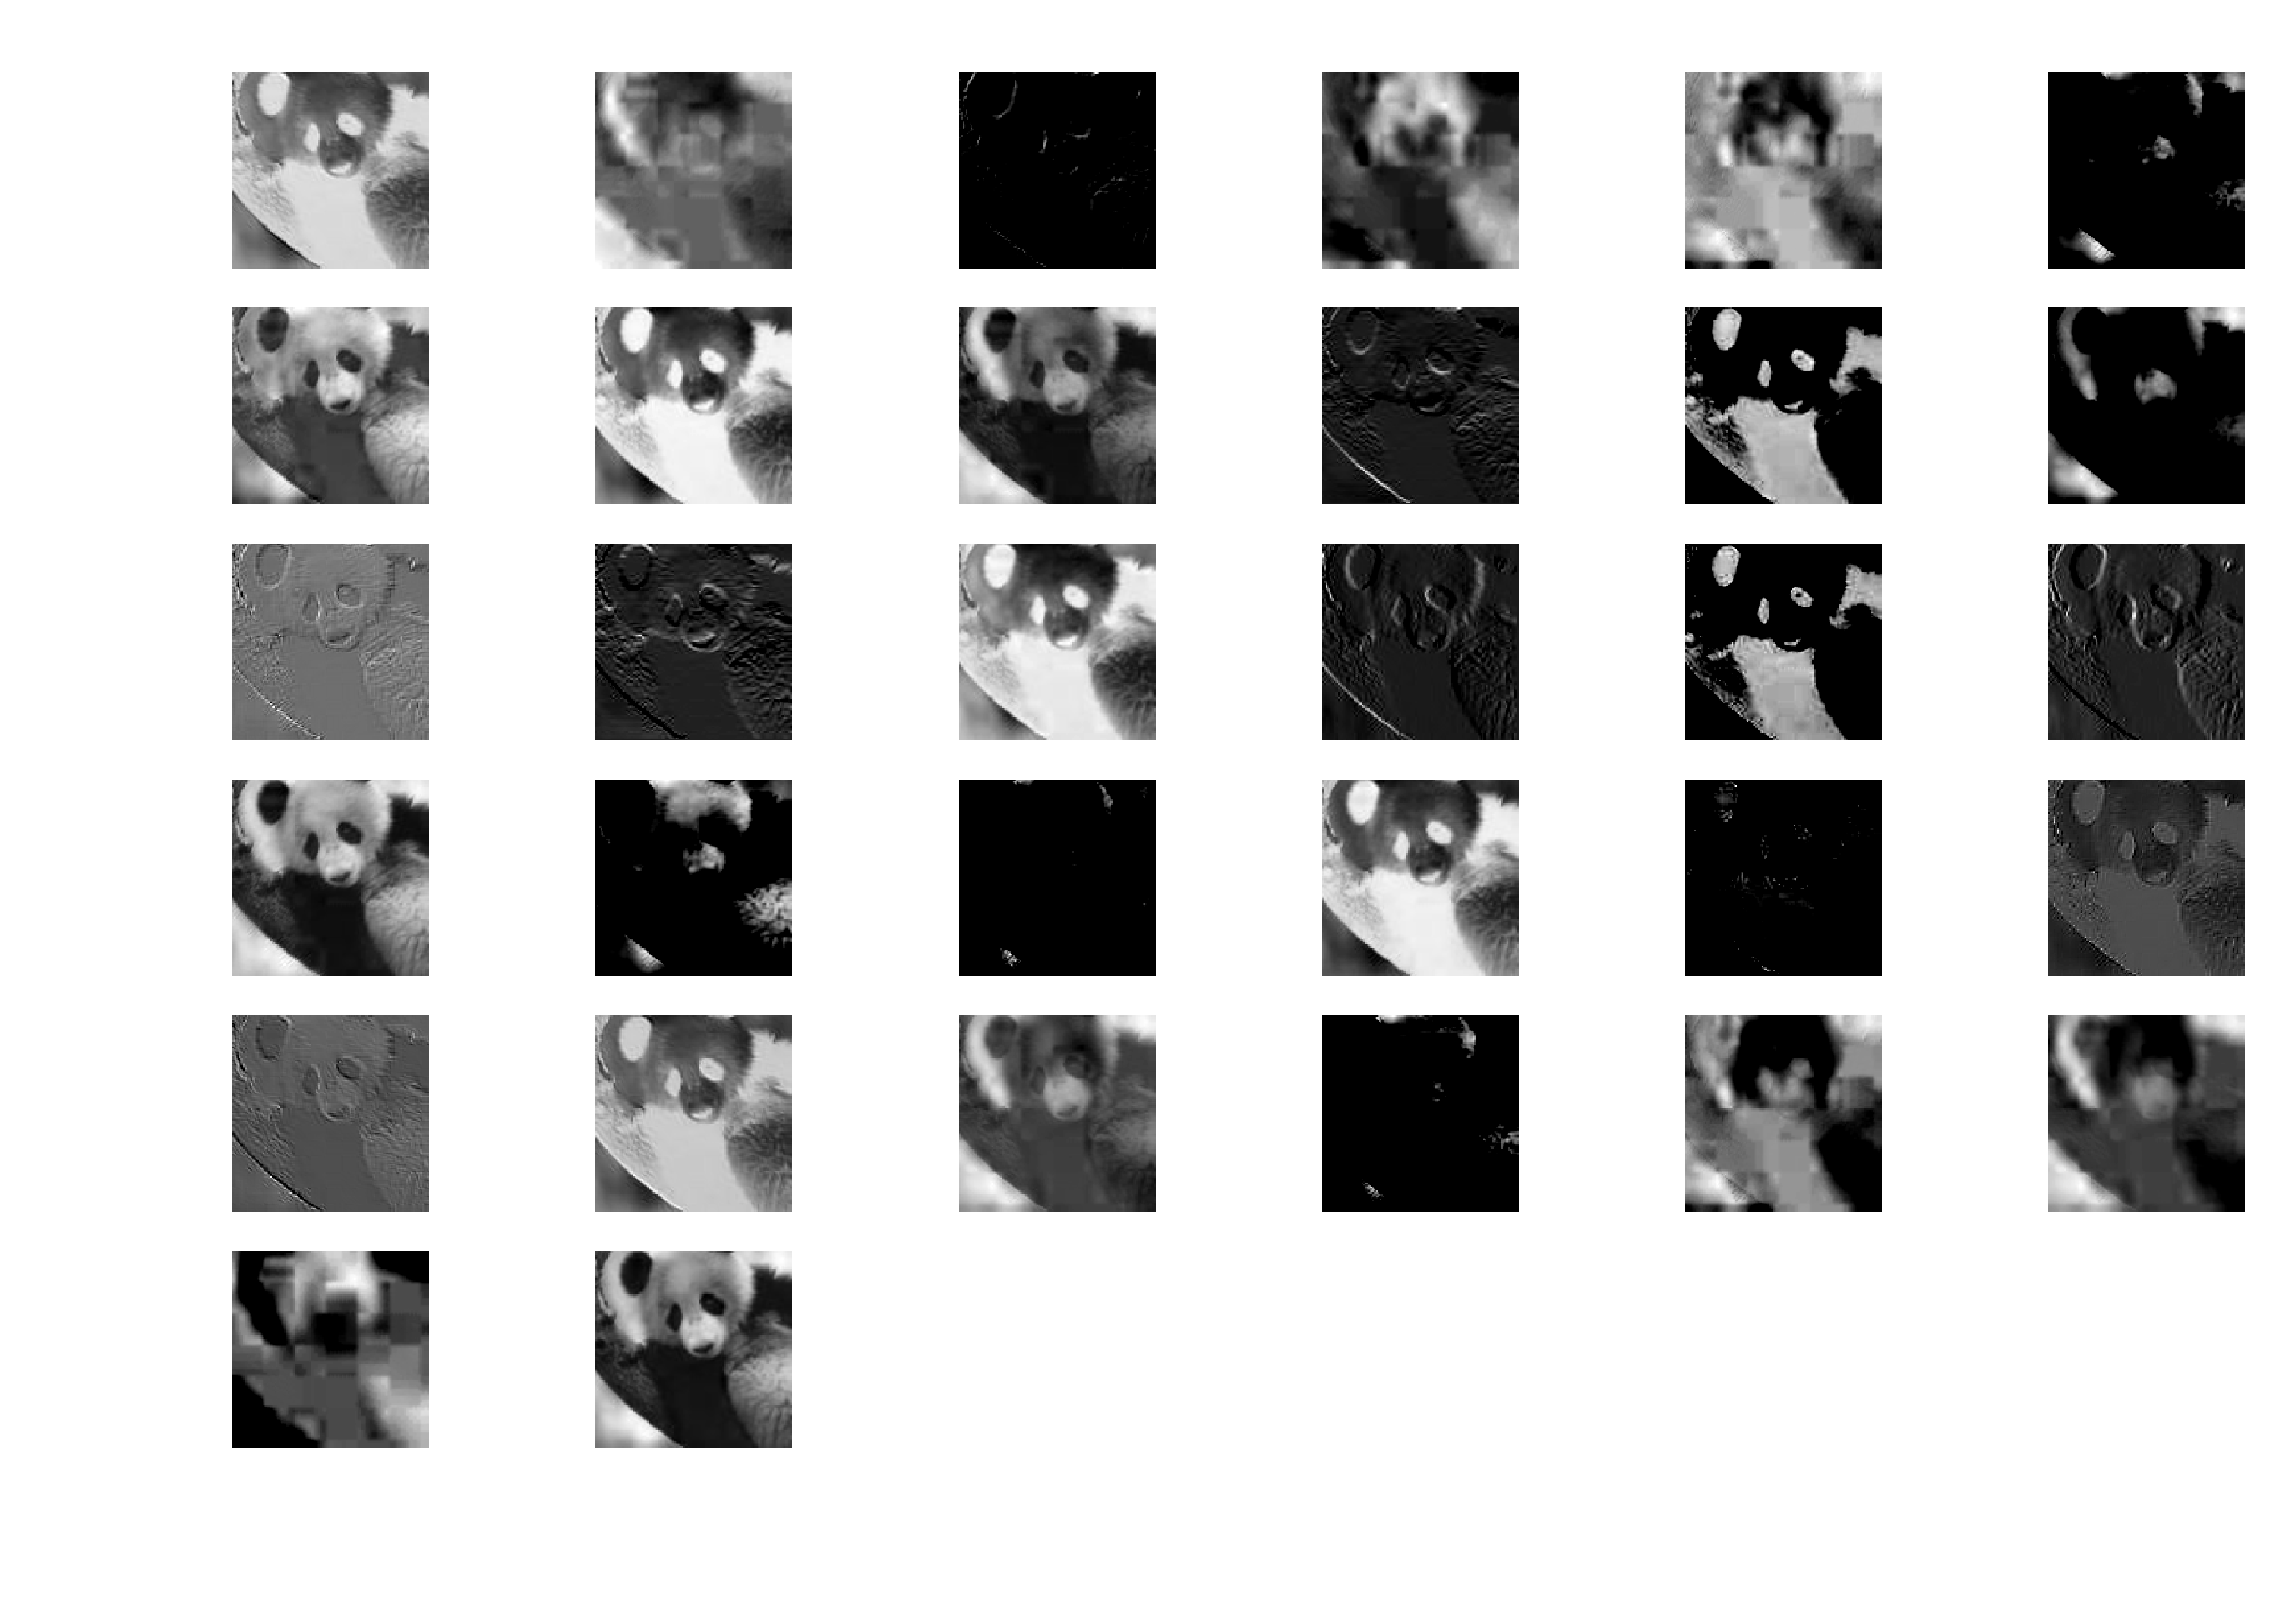

In [81]:
for i in range(visualization.shape[-1]):
    plt.subplot(6,6, i+1)
    plt.imshow(visualization[:,:,i])
    plt.axis('off')